# Python 
Python is an incredible and versatile language embedded a powerful ecosystem. For data
science 
the Pandas library is a powerful "Swiss Army Knife".

However in economic and for modeling banks we need to be able to include **lagged variables**
in transformation and to handle **simultaneous formulas** (circular references in Excel speak). 

**ModelFlow** is a toolkit to enable such features - and much more.

This is a Jupyter notebook. Jupyter is a Python Shell 

You will notice **input cells** (marked:In\[\]) and **output cells** (marked: Out\[\]) 

It is live, so you can try it out yourself, if you have access to the
ModelFlow toolkit, else you just have to watch.

This Jupyter notebook will take you to a tour of how make models with lagged variables in
ModelFlow. 

The notebook focus on a simple example and do not explore all the features and
options. Also the models are toy models created to be small but still illustrative.

In [1]:
import pandas as pd               # Python data science library
from modelclass import model      # modelclass from ModelFlow 

# Create a Pandas Dataframe
We make up some data.

Pandas dataframes are tables with **row** and **column** names. Columns are variables, and rows are the time dimension. 

In [2]:
df = pd.DataFrame({'LOAN': [100,100,100,100],'SECURITIES':[10,11,12,13],
                   'CASH':[4,4,4,4],'DEPOSIT': [100,100,100,100],
                   'BONDS':[1,2,3,4],'NEW_LOAN':[1,20,30,40] },
                  index=[2018,2019,2020,2021])
df

,LOAN,SECURITIES,CASH,DEPOSIT,BONDS,NEW_LOAN
2018,100,10,4,100,1,1
2019,100,11,4,100,2,20
2020,100,12,4,100,3,30
2021,100,13,4,100,4,40


# A simple model. Pandas works fine. 
The pandas dataframe contains a fast and powerful evaluation method. It will do the transformation on
based on columns.

In [3]:
df.eval('''\
ASSETS  = LOAN + SECURITIES + CASH
FUNDING = DEPOSIT + BONDS
EQUITY  = ASSETS - FUNDING ''')

,LOAN,SECURITIES,CASH,DEPOSIT,BONDS,NEW_LOAN,ASSETS,FUNDING,EQUITY
2018,100,10,4,100,1,1,114,101,13
2019,100,11,4,100,2,20,115,102,13
2020,100,12,4,100,3,30,116,103,13
2021,100,13,4,100,4,40,117,104,13


# Notice
The eval method will calculate each column in one go for all years. This allows it to use vectorization in order to speed up the calculations. 

However, if we want to make dynamic transformation with lagged variables, we need to calculate each year for all variables and step on the to the next year. 

Lets take a look. 

# Now a model, where Pandas don't work out of the box 
We want to introduce a little more dynamic in the model. So we introduce three flows: NEW_LOAN, NEW_DEPOSITS and NEW_BONDS

-  NEW_LOAN is added to  LOAN from last year

-  NEW_DEPOSITS is added to DEPOSITS from last year

-  NEW_BONDS funds new loans not funded by new deposits.


In [4]:
fmodel = '''\
ASSETS  = LOAN + SECURITIES + CASH
FUNDING = DEPOSIT + BONDS
EQUITY  = ASSETS - FUNDING  

DEPOSIT = DEPOSIT(-1) + NEW_DEPOSIT
LOAN = LOAN(-1)+  NEW_LOAN 
NEW_BONDS =  (NEW_LOAN - NEW_DEPOSIT) 
BONDS = BONDS(-1) + NEW_BONDS'''

   
To  implement this model, the build-in function **eval** is not suited, as we can't calculate row by row. 

So we use ModelFlow to create a model instance which can calculate the model. ModelFlow contains a factory called **model** which will create an function (actually a class instance, more on that later), which then can calculate the model.      

In [5]:
a_model =model(fmodel)

# And run an experiment
Now we can apply the function to the dataframe, and gets the results.

In [6]:
a_model(df)

Will start calculating: testmodel
2019  solved
2020  solved
2021  solved
testmodel calculated 


,LOAN,SECURITIES,CASH,DEPOSIT,BONDS,NEW_LOAN,NEW_BONDS,NEW_DEPOSIT,FUNDING,EQUITY,ASSETS
2018,100.0,10.0,4.0,100.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2019,120.0,11.0,4.0,100.0,21.0,20.0,20.0,0.0,121.0,14.0,135.0
2020,150.0,12.0,4.0,100.0,51.0,30.0,30.0,0.0,151.0,15.0,166.0
2021,190.0,13.0,4.0,100.0,91.0,40.0,40.0,0.0,191.0,16.0,207.0


# Notice:
* The model is run from 2019, in order to take account of the lags
* The model is calculated even when the formulas where not in the logical order. 
* Variables in the model missing from the dataframe are set to 0

# Now we can make transformations with lagged variables. But there is much more 
The result from a model run can be used straight in python programs. However **it can be done better**. The **a_model** is not just a calculation function. It is a instance of a class called **model**. 

To make the life easy for the user the model instance has additional capabilities. It retains a number of useful information regarding the model and the solutions. This makes it a powerful tool for model and result analysis.

# Results and dependencies are properties of the model instance
The model instance contains a number data items (python class properties), among other:

*  the first and last solution of the model
*  the directed graph of which variable contributes to which variable
*  all formulas in the model 
This allows a number of capabilities of which some will be shown in the following.

# Make another experiment 
First we update some exogenous variables (variables which are only on the right hand side of the model). Then we run the model again. 

In [7]:
df['NEW_LOAN']= [1,40,50,80]
df['NEW_DEPOSIT']= [1,30,20,50]
a_model(df)

Will start calculating: testmodel
2019  solved
2020  solved
2021  solved
testmodel calculated 


,LOAN,SECURITIES,CASH,DEPOSIT,BONDS,NEW_LOAN,NEW_DEPOSIT,NEW_BONDS,ASSETS,FUNDING,EQUITY
2018,100.0,10.0,4.0,100.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2019,140.0,11.0,4.0,130.0,11.0,40.0,30.0,10.0,155.0,141.0,14.0
2020,190.0,12.0,4.0,150.0,41.0,50.0,20.0,30.0,206.0,191.0,15.0
2021,270.0,13.0,4.0,200.0,71.0,80.0,50.0,30.0,287.0,271.0,16.0


# Visualizing 
Using results stored as properties in the model instance, the results can be compared and visualized. 

In order to make life easy when using models with consistent and structured variable naming conventions wildcards can be used to select the variables to visualize through ModelFlow. 

If this is not sufficient the whole suite of Python visualization (as Matplotlib, Seaborn, Plotly) can be used on top of the resulting dataframes. 

# Plot the last result

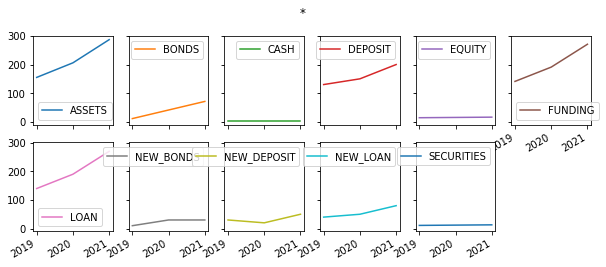

In [8]:
_ = a_model['*'].plot()

# Plot the difference between the first and last run 

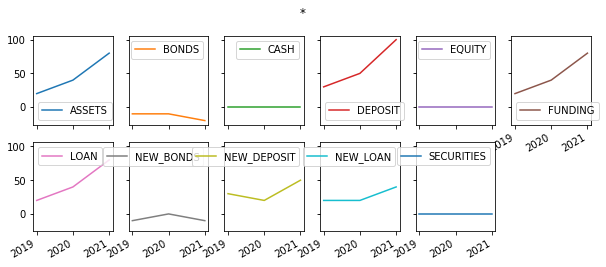

In [9]:
_ = a_model['*'].dif.plot()

# Or as heatmap 

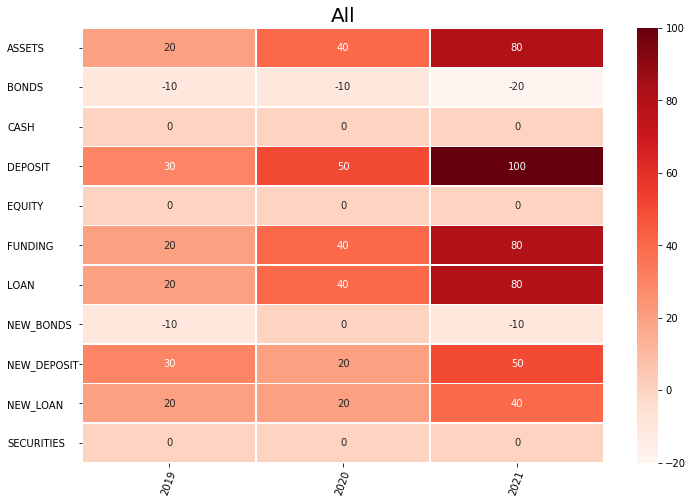

In [10]:
_ = a_model['*'].dif.heat(title='All',annot=True)

# The stucture of the model (dependency graph)

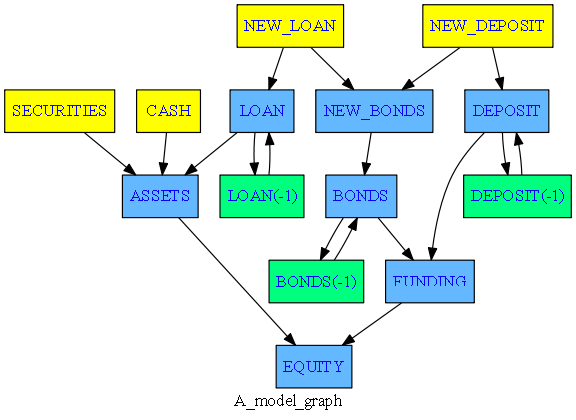

In [11]:
a_model.drawmodel()

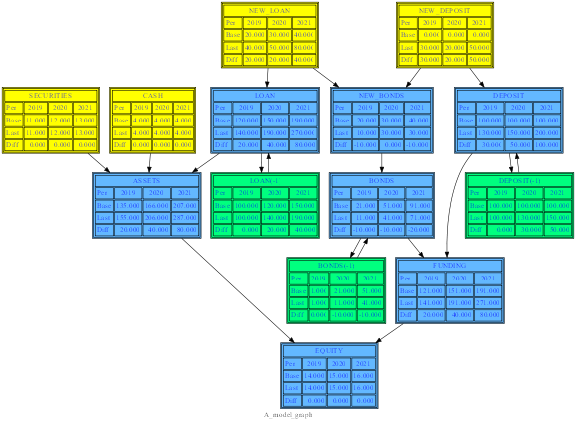

In [12]:
a_model.drawmodel(all=1,pdf=1) 

# What explains the difference for a variable 
Which of the input variables explains the difference of the results of a formula between two runs.

If we have:

$y = f(a,b)$

and we have two solutions where the variables differs by $\Delta y, \Delta a, \Delta b$

How much of $\Delta y$ can be explained by $\Delta a$ and $\Delta b$ ?

Analytical the attributions $\Omega a$ and $\Omega b$ can  be calculated like this: 

$\Delta y = \underbrace{\Delta a \frac{\partial {f}}{\partial{a}}(a,b)}_{\Omega a} + 
\underbrace{\Delta b \frac{\partial {f}}{\partial{b}}(a,b)}_{\Omega b}+Residual$

If we have two experiments:

\begin{eqnarray}  
y_0&=&𝑓(a_{0},b_{0}) \\
y_1&=&𝑓(a_0+\Delta a,b_{0}+ \Delta b)
\end{eqnarray}

ModelFlow will do a numerical approximation of $\Omega a$ and $\Omega b$.

\begin{eqnarray}  
\Omega f_a&=&f(a_1,b_1 )-f(a_1-\Delta a,b_1) \\
\Omega f_b&=&f(a_1,b_1 )-f(a_1,b_1-\Delta  b)
\end{eqnarray}



If the model is fairly linear, the residual will be small. 

\begin{eqnarray}
residual = \Omega f_a + \Omega f_b -(y_1 - y_0) 
\end{eqnarray}

Now look at generations of attributions 

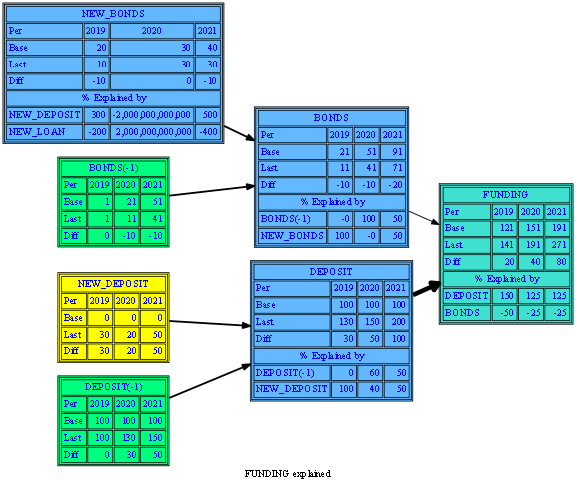

In [16]:
_=a_model.FUNDING.explain(up=2,HR=0,pdf=0)

# Beyond a simpel model

This was a simple model. You don't even need a computer to solve it, or you could use Excel to handle the model.  However sometime you want to:

* Use a a more rich business logic language
* Let variables be matrices or even dataframes 
* Scale to large model (even millions of equations)
* Handle simultaneous models
* Make identical models for a lot of banks/sectors or whatever
* Solve models fast  
* Grab a model from Matlab/Dynare
* Grab a model from Excel 
* Grab a model from Latex
* Attribute difference between scenarios to individual variables or groups of variables.
* Speed up the model by compiling the model 
* Invert the model to solve for targets as function of instruments.
* Linearize the model using symbolic differentiation 
* Calculate stability of a linearized model. 

Then dig deeper into ModelFlow. 

# The core of ModelFlow
Is to take a model like this: 

In [14]:
print(a_model.equations)

FRML  <> ASSETS  = LOAN + SECURITIES + CASH $
FRML  <> FUNDING = DEPOSIT + BONDS $
FRML  <> EQUITY  = ASSETS - FUNDING   $
FRML  <> DEPOSIT = DEPOSIT(-1) + NEW_DEPOSIT $
FRML  <> LOAN = LOAN(-1)+  NEW_LOAN  $
FRML  <> NEW_BONDS =  (NEW_LOAN - NEW_DEPOSIT)  $
FRML  <> BONDS = BONDS(-1) + NEW_BONDS $


And transform it to
this python function, which will calculate the results: 

In [15]:
print(a_model.make_los_text)

def make_los(funks=[]):
    from modeluserfunk import pd_to_w, pd_to_w_corp, pd_to_w_mrtg, pd_to_w_retail, phi, phiinv
    from modelBLfunk import array, classfunk, exp, inspect, log, logit, matrix, mv_opt, mv_opt_prop, norm, normcdf, sum_excel, transpose
    def los(values,row,solveorder, allvar):
        try :
            values[row,0]=values[row-1,0]+values[row,5]
            values[row,8]=values[row,0]+values[row,1]+values[row,2]
            values[row,7]=(values[row,5]-values[row,6])
            values[row,4]=values[row-1,4]+values[row,7]
            values[row,3]=values[row-1,3]+values[row,6]
            values[row,9]=values[row,3]+values[row,4]
            values[row,10]=values[row,8]-values[row,9]
        except :
            print("Error in",allvar[solveorder[sys.exc_info()[2].tb_lineno-6]]["frml"])
            raise
        return 
    return los



This is all done in the ModelFlow.model class and the user most probably will never be aware of the function above. 